In [1]:
import pandas as pd 
import numpy as np

In [2]:
# Lecture des données
WGI_raw = pd.read_csv("/kaggle/input/worldwide-governance-indicators/WGI_Data.csv", sep=",")

In [3]:
WGI_raw.shape

(1284, 5)

In [4]:
WGI_raw.head()

,Country Name,Country Code,Series Name,Series Code,Value
0,Afghanistan,AFG,Control of Corruption: Estimate,CC.EST,-1.56373512744904
1,Afghanistan,AFG,Government Effectiveness: Estimate,GE.EST,-1.2221063375473
2,Afghanistan,AFG,Political Stability and Absence of Violence/Te...,PV.EST,-2.74916744232178
3,Afghanistan,AFG,Regulatory Quality: Estimate,RQ.EST,-1.32791936397552
4,Afghanistan,AFG,Rule of Law: Estimate,RL.EST,-1.61642956733704


# Préparation du jeu de données

In [5]:
# Tranformation en réel des valeurs 
WGI_raw["Value"] = [None if v == ".." else float(v) for v in WGI_raw["Value"]]

In [6]:
defcols = pd.DataFrame(data = {
    "Code" : ['CC.EST', 'GE.EST', 'PV.EST', 'RQ.EST', 'RL.EST', 'VA.EST'],
    "Serie": ['CorruptionControl', 'GovEffectiveness', 'PoliticalStability', 'RegulatoryQuality', 'RuleLaw',  'VoiceAccountability']
})

In [7]:
# Jointure des 2 tables
WGI_raw = WGI_raw.merge(defcols, left_on = "Series Code", right_on = "Code")

In [8]:
# récupération des continents
Continent = pd.read_csv("/kaggle/input/worldwide-governance-indicators/continent.csv", sep = ";")

In [9]:
Continent.head()

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12.0
4,Oceania,OC,American Samoa,AS,ASM,16.0


In [10]:
Continent = Continent.drop(columns = ["Continent_Code", "Two_Letter_Country_Code", "Country_Number"])

In [11]:
# Filtres sur des pays à cheval entre Europe et Asie
Continent = Continent.query("not(Three_Letter_Country_Code.isin(['ARM', 'CYP', 'AZE', 'TUR', 'KAZ', 'GEO', 'RUS']) & Continent_Name == 'Asia')")

In [12]:
WGI_raw = WGI_raw.merge(Continent, how = 'left', left_on = "Country Code", right_on = "Three_Letter_Country_Code")

In [13]:
# Modification de la forme de la table
WGI = pd.pivot_table(WGI_raw.reset_index(), index = ['Country_Name', "Continent_Name"], columns = "Serie", values = "Value")

In [14]:
WGI = WGI.reset_index()
WGI

Serie,Country_Name,Continent_Name,CorruptionControl,GovEffectiveness,PoliticalStability,RegulatoryQuality,RuleLaw,VoiceAccountability
0,"Afghanistan, Islamic Republic of",Asia,-1.563735,-1.222106,-2.749167,-1.327919,-1.616430,-1.086220
1,"Albania, Republic of",Europe,-0.397567,-0.000573,0.257720,0.188962,-0.347468,0.159191
2,"Algeria, People's Democratic Republic of",Africa,-0.691359,-0.544695,-1.139282,-1.171843,-0.849319,-0.877241
3,American Samoa,Oceania,1.230341,0.531472,1.192534,0.136647,1.328246,NaN
4,"Andorra, Principality of",Europe,1.230341,1.860201,1.396047,0.871409,1.564011,1.197540
...,...,...,...,...,...,...,...,...
205,"Venezuela, Bolivarian Republic of",South America,-1.392557,-1.293382,-1.026120,-1.996909,-2.178493,-1.134777
206,"Vietnam, Socialist Republic of",Asia,-0.396315,0.010342,0.168574,-0.453935,0.048006,-1.407117
207,Yemen,Asia,-1.668297,-1.819497,-2.793776,-1.479933,-1.600989,-1.651756
208,"Zambia, Republic of",Africa,-0.396116,-0.658354,0.183082,-0.483631,-0.302031,-0.300023


# Analyse de données sous python

In [15]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")

# permet d'afficher les graphiques dans un notebook
%matplotlib inline

Pour appliquer les deux méthodes, nous allons réaliser une étude de cas, avec les données WGI. Celles-ci donnent certains indicateurs sur la gouvernance des pays. Voici donc le code pour les importer dans un data frame pandas, et leur aperçu. Pour information, plus la valeur est haute, meilleur est le pays sur cet indicateur (et inversement).

## Analyse en composante principal

Dans le sous-module decomposition, nous allons importer la fonction PCA(). Le fonctionnement de celle-ci est similaire à toutes les autres dans scikit-learn.

On créé d'abord un objet (nommé ici pca) qui va contenir le résultat de l'ACP. Dans la fonction PCA(), on pourra aussi indiquer les paramètres tels que le nombre de composants à retenir (n_components - ici on garde tout).
Ensuite, on ajuste (fit en anglais) sur des données avec la fonction fit() de l'objet précédemment créé. Dans cette fonction, nous devons donc passer les données à utiliser (variables uniquement quantitatives).
Si l'on souhaite une ACP normée (ce qui n'est pas le cas ici), il nous faut standardiser les données en amont, avec par exemple la fonction scale() du sous-module preprocessing (importée aussi ici). Bien évidemment, il ne faut passer que des variables quantitatives, sans données manquantes.

In [16]:
WGI.dropna(inplace=True)

In [17]:
WGI.shape

(201, 8)

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# suppression des colonnes non numériques
WGI_num = WGI.drop(columns = ["Country_Name", "Continent_Name"])
pca = PCA()
pca.fit(WGI_num) 

PCA()

### Variance expliquée
L'objet pca comprend maintenant un certain nombre d'objets et de fonctions. Le premier objet est le tableau des variances expliquées (explained_variance_ - proportionnelles aux valeurs propres) par chaque dimension, et le ratio (proportion) de variance expliquée par dimension (explained_variance_ratio_).

In [19]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[5.02734546 0.47250134 0.31926518 0.11493585 0.05219518 0.04079811]
[0.8341316  0.0783969  0.05297213 0.01907003 0.00866017 0.00676918]


Bien évidemment, il est possible (et préférable) de faire un tableau récapitulatif, avec les variances expliquées, les proportions de variance expliquée simples et cumulées. Voici un petit code permettant de faire ceci.

In [20]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(6)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,5.027345,83.0,83.0
1,Dim2,0.472501,8.0,91.0
2,Dim3,0.319265,5.0,97.0
3,Dim4,0.114936,2.0,98.0
4,Dim5,0.052195,1.0,99.0
5,Dim6,0.040798,1.0,100.0


L'idée est de représenter graphiquement ces proportions de variances expliquées (qu'on passe en pourcentage par convenance).

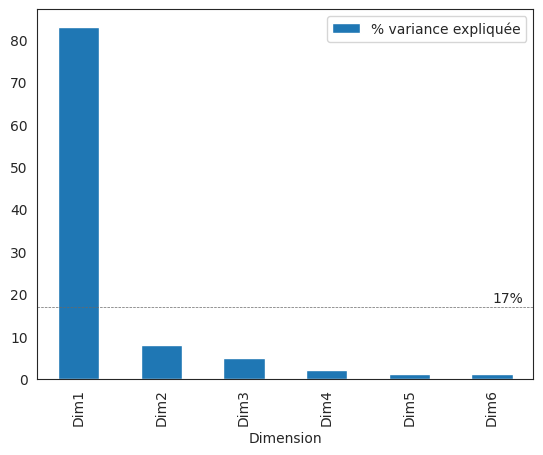

In [21]:
eig.plot.bar(x = "Dimension", y = "% variance expliquée") # permet un diagramme en barres
plt.text(5, 18, "17%") # ajout de texte
plt.axhline(y = 17, linewidth = .5, color = "dimgray", linestyle = "--") # ligne 17 = 100 / 6 (nb dimensions)
plt.show()

On remarque ici qu'avec seulement deux dimensions suffisent à expliquer 91 % de la variance des données.

## Représentation des individus

Nous allons maintenant calculer les coordonnées des iris sur les dimensions, avec la fonction transform() de l'objet pca.

In [22]:
WGI_pca = pca.transform(WGI_num)

Afin de manipuler plus facilement l'objet obtenu par la suite, nous allons créer un DataFrame pandas en ne prenant que les deux premières dimensions, ainsi que les espèces.

In [23]:
# Transformation en DataFrame pandas
WGI_pca_df = pd.DataFrame({
    "Dim1" : WGI_pca[:,0], 
    "Dim2" : WGI_pca[:,1],
    "Country" : WGI["Country_Name"],
    "Continent" : WGI["Continent_Name"]
})

# Résultat (premières lignes)
WGI_pca_df.head()

,Dim1,Dim2,Country,Continent
0,3.790973,-0.936333,"Afghanistan, Islamic Republic of",Asia
1,0.019583,0.287254,"Albania, Republic of",Europe
2,2.063085,-0.340833,"Algeria, People's Democratic Republic of",Africa
4,-3.385678,0.124952,"Andorra, Principality of",Europe
5,2.439518,0.228024,"Angola, Republic of",Africa


Il est maintenant possible de représenter les données sur le premier plan factoriel. Dans ce graphique, il est important de noter le pourcentage de variance expliquée.

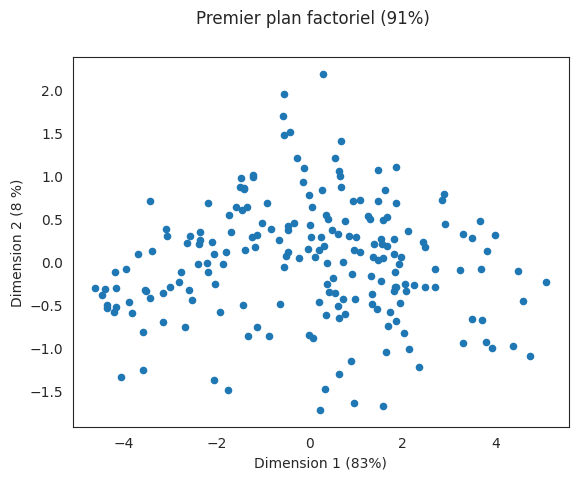

In [24]:
WGI_pca_df.plot.scatter("Dim1", "Dim2") # nuage de points
plt.xlabel("Dimension 1 (83%)") # modification du nom de l'axe X
plt.ylabel("Dimension 2 (8 %)") # idem pour axe Y
plt.suptitle("Premier plan factoriel (91%)") # titre général
plt.show()

Dans ce même graphique, on veut repérer les individus aux extrêmes. Ci-dessous, nous affichons donc les noms des pays ayant des valeurs absolues élevées pour chaque composante.

On pourrait aussi se demander s'il y a un effet continent. Pour cela, nous allons colorer les points en fonction de leur continent donc.

In [25]:
# permet de créer une palette de couleurs, basée sur Color Brewer
palette = plt.get_cmap("Dark2")
# associe une couleur à chaque continent (cf ci-dessous)
couleurs = dict(zip(WGI_pca_df["Continent"].drop_duplicates(), palette(range(6))))
couleurs

{'Asia': array([0.10588235, 0.61960784, 0.46666667, 1.        ]),
 'Europe': array([0.85098039, 0.37254902, 0.00784314, 1.        ]),
 'Africa': array([0.45882353, 0.43921569, 0.70196078, 1.        ]),
 'North America': array([0.90588235, 0.16078431, 0.54117647, 1.        ]),
 'South America': array([0.4       , 0.65098039, 0.11764706, 1.        ]),
 'Oceania': array([0.90196078, 0.67058824, 0.00784314, 1.        ])}

Une fois qu'on a associé une couleur à chaque continent, on peut utiliser ce dictionnaire comme ci-dessous

In [26]:
couleurs["Asia"]

array([0.10588235, 0.61960784, 0.46666667, 1.        ])

In [27]:
position = dict(zip(couleurs.keys(), range(6)))
position

{'Asia': 0,
 'Europe': 1,
 'Africa': 2,
 'North America': 3,
 'South America': 4,
 'Oceania': 5}

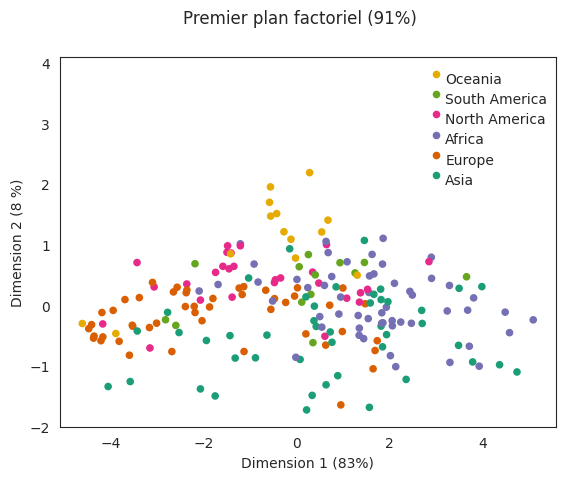

In [28]:
# Affichage des points avec une liste de couleurs
WGI_pca_df.plot.scatter(x = "Dim1", y = "Dim2", c = [couleurs[p] for p in WGI_pca_df["Continent"]])
# boucle pour afficher la légende
for cont, coul in couleurs.items():
    plt.scatter(3, position[cont] / 3 + 2.15, c = [coul], s = 20)
    plt.text(3.2, position[cont] / 3 + 2, cont)
plt.xlabel("Dimension 1 (83%)") 
plt.ylabel("Dimension 2 (8 %)")
plt.suptitle("Premier plan factoriel (91%)")
plt.show()

Il est aussi possible de différencier l'affichage de ce premier plan par continent.

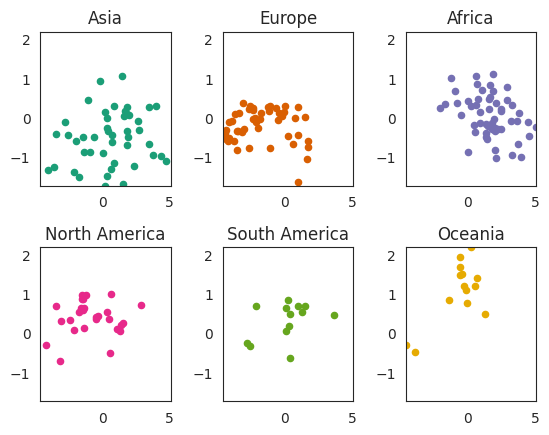

In [29]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for cont, coul in couleurs.items():
    ax = fig.add_subplot(2, 3, position[cont] + 1)
    temp = WGI_pca_df.query('Continent == "' + cont + '"')
    temp.plot.scatter(x = "Dim1", y = "Dim2", c = [coul], ax = ax)
    ax.set_title(cont)
    ax.set_xlim(WGI_pca_df.Dim1.quantile([0, 1])) # permet d'avoir min et max
    ax.set_ylim(WGI_pca_df.Dim2.quantile([0, 1])) # idem
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.show()

## Représentation des variables

Lorsqu'on réalise une ACP, surtout dans un contexte exploratoire (et non de compression), il est absolument nécessaire de décrire les axesà partir des variables, afin de comprendre ce qu'ils représentent. Pour cela, nous devons réaliser le cercle des corrélations. Malheureusement, il faut le réaliser à la main.

In [30]:
n = WGI_num.shape[0] # nb individus
p = WGI_num.shape[1] # nb variables
eigval = (n-1) / n * pca.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': WGI_num.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar

,id,COR_1,COR_2
0,CorruptionControl,-0.953077,-0.087238
1,GovEffectiveness,-0.944814,-0.251061
2,PoliticalStability,-0.821878,0.434985
3,RegulatoryQuality,-0.939355,-0.251006
4,RuleLaw,-0.977861,-0.108867
5,VoiceAccountability,-0.828987,0.368022


Une fois ces coordonnées récupérées, on peut donc afficher ce cercle des corrélations comme ci-dessous.

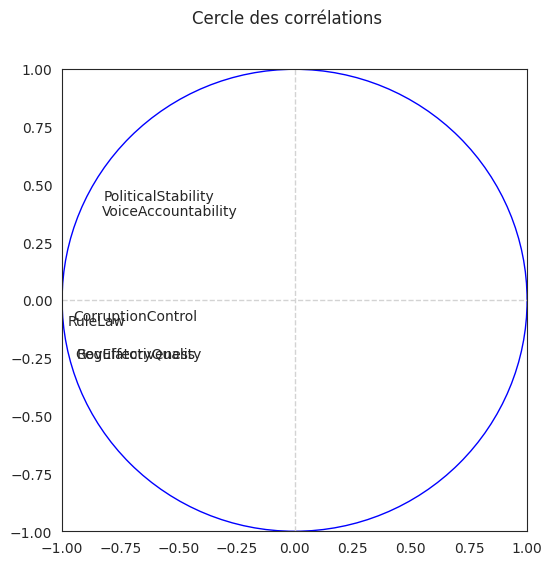

In [31]:
# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

Ici, on va en déduire que l'axe 1 oppose à gauche les pays avec une forte valeur dans tous les indicateurs (ils sont tous à gauche), et à droite les pays à faible valeur pour ces indicateurs.

L'axe 2 semble opposer les pays avec une valeur positive pour les indicateurs sur la statibilité politique et la prise en compte de l'avis des citoyens en haut, avec les pays avec une valeur négative pour ces 2 indicateurs en bas.

Vous pouvez revenir sur le graphique des pays pour mieux comprendre.